In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display

import tensorflow.keras.backend as K
from scipy.stats import norm
from tensorflow.keras import (layers, models, callbacks, datasets, losses, metrics, optimizers)

import warnings
warnings.filterwarnings("ignore")

In [2]:
(x_train , y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

def preprocess(img):
    img = img.astype("float32") / 255.0
    img = np.pad(img, ((0,0),(2,2),(2,2)), constant_values=0.0)
    img = np.expand_dims(img, -1)
    return img

x_train = preprocess(x_train)
x_test = preprocess(x_test)

class Sampling(layers.Layer):
    def call (self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

4422102/4422102 [==============================] - 2s 0us/step


In [6]:
#encode
encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!
x = layers.Flatten()(x)
z_mean = layers.Dense(units=2, name="z_mean")(x)
z_log_var = layers.Dense(units=2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#decode
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1,(3, 3),strides=1,activation="sigmoid",padding="same",name="decoder_output")(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_4 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_4[0][0]']            
                                                                                            

In [4]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = "./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only = True,
    verbose=0
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [7]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker,]
        
    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
        
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(500 * losses.binary_crossentropy(data, reconstruction, axis=(1,2,3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1,))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name : m.result() for m in self.metrics}
        
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(500 * losses.binary_crossentropy(data, reconstruction, axis=(1,2,3)))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 *(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1,))
        total_loss = reconstruction_loss + kl_loss
        return {"loss":total_loss,
               "reconstruction_loss":reconstruction_loss,
               "kl_loss":kl_loss}

vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer) #loss="binary_crossentropy"
vae.fit(x_train,  batch_size=1000, validation_data=(x_test, x_test), epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/10


2024-03-04 10:23:42.346648: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-04 10:23:42.561079: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-04 10:23:43.425230: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-04 10:23:43.929280: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.93GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-04 10:23:44.300414: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.93GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance 

60/60 [==============================] - 24s 222ms/step - total_loss: 259.9226 - reconstruction_loss: 256.6636 - kl_loss: 3.2590 - val_loss: 201.7527 - val_reconstruction_loss: 198.4845 - val_kl_loss: 3.2682
Epoch 2/10
60/60 [==============================] - 13s 217ms/step - total_loss: 179.1947 - reconstruction_loss: 175.1633 - kl_loss: 4.0314 - val_loss: 165.7343 - val_reconstruction_loss: 161.5597 - val_kl_loss: 4.1746
Epoch 3/10
60/60 [==============================] - 13s 220ms/step - total_loss: 156.5460 - reconstruction_loss: 152.1846 - kl_loss: 4.3613 - val_loss: 153.9822 - val_reconstruction_loss: 149.5203 - val_kl_loss: 4.4619
Epoch 4/10
60/60 [==============================] - 13s 219ms/step - total_loss: 147.7265 - reconstruction_loss: 143.1085 - kl_loss: 4.6180 - val_loss: 147.8554 - val_reconstruction_loss: 143.1914 - val_kl_loss: 4.6641
Epoch 5/10
60/60 [==============================] - 13s 219ms/step - total_loss: 142.2618 - reconstruction_loss: 137.4789 - kl_loss: 4.

In [8]:
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


In [12]:
example_images = x_test[:5000]
example_labels = y_test[:5000]

z_mean, z_log_var, reconstruction = vae.predict(example_images)
print("example images")
display(example_images)
print("reconstructed")
display(reconstruction)

157/157 [==============================] - 1s 6ms/step
example images


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

reconstructed


array([[[[9.16809004e-05],
         [1.84512123e-06],
         [1.00083651e-06],
         ...,
         [8.87077761e-07],
         [3.01563341e-06],
         [5.84406196e-04]],

        [[4.20685956e-06],
         [5.25536770e-08],
         [3.41160877e-08],
         ...,
         [2.23190298e-07],
         [2.62385186e-07],
         [6.05547175e-05]],

        [[2.02947035e-06],
         [3.63968233e-08],
         [4.87664344e-08],
         ...,
         [5.78533900e-06],
         [1.10110796e-06],
         [8.85217814e-05]],

        ...,

        [[8.70764507e-06],
         [7.42171551e-07],
         [1.56718784e-06],
         ...,
         [6.68299663e-06],
         [2.81389748e-06],
         [1.36571296e-04]],

        [[1.01427413e-05],
         [5.45074215e-07],
         [7.88487682e-07],
         ...,
         [2.34759341e-07],
         [1.91854411e-07],
         [4.57310998e-05]],

        [[3.10410076e-04],
         [3.14402059e-05],
         [2.37719996e-05],
         ...,
 

157/157 [==============================] - 0s 3ms/step
[[-1.0980417   0.5243229 ]
 [ 0.31371564 -0.89093876]
 [ 2.1074793  -0.14112704]
 [ 2.100595    0.94568175]
 [ 0.32141316 -0.16488492]
 [ 1.6039182  -0.22760952]
 [ 0.45429704  1.2057812 ]
 [ 0.37545824  0.6391014 ]
 [-1.7522917   1.821022  ]
 [-1.891013    0.6927444 ]]


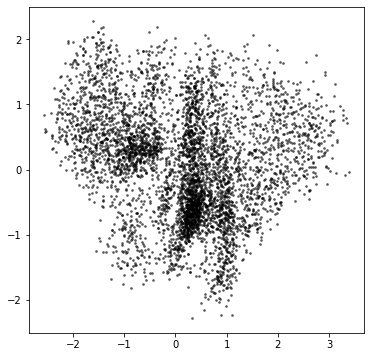

In [13]:
#embed using encoder
z_mean, z_var, z = encoder.predict(example_images)
print(z[:10])
plt.figure(figsize=(6,6))
plt.scatter(z[:,0], z[:,1], c="black", alpha=0.5, s=3)
plt.show()


1/1 [==============================] - 1s 516ms/step


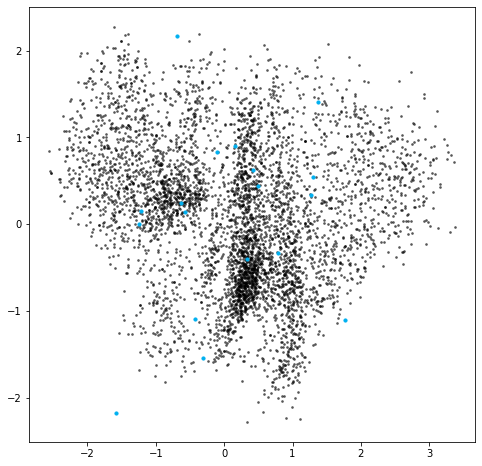

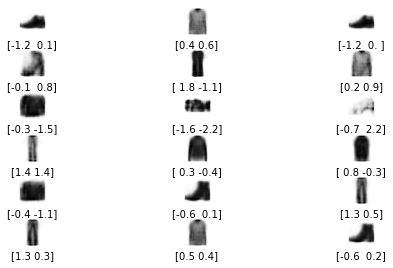

In [14]:
#generate using decoder
z_sample = np.random.normal(size=(6*3,2))
reconstructions = decoder.predict(z_sample)
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

plt.figure(figsize=(8,8))
plt.scatter(z[:,0], z[:,1], c="black", alpha=0.5, s=3)
plt.scatter(z_sample[:,0], z_sample[:,1], c="#00B0F0", alpha=1, s=10)
plt.show()
fig = plt.figure(figsize=(8,3*2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(6*3):
    ax = plt.subplot(8,3, i+1)
    ax.axis("off")
    ax.text(0.5, -0.35, str(np.round(z_sample[i,:],1)), fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(reconstructions[i,:,:], cmap="Greys")

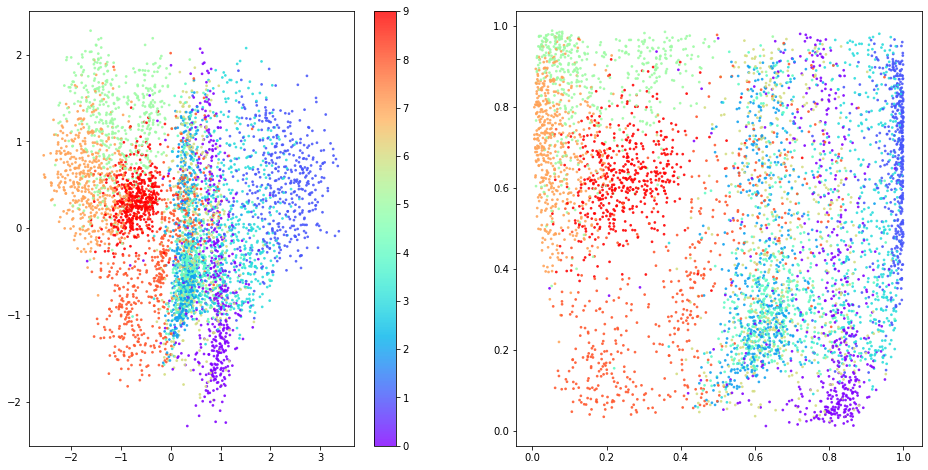

8/8 [==============================] - 0s 51ms/step


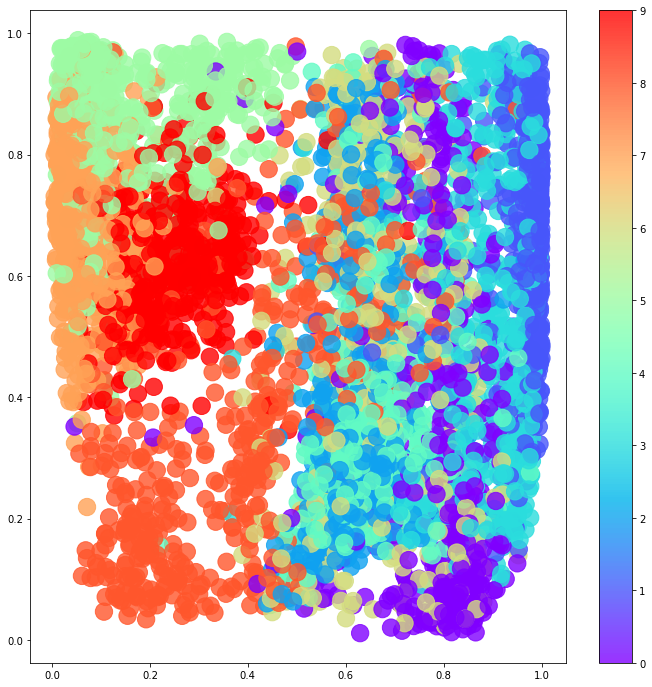

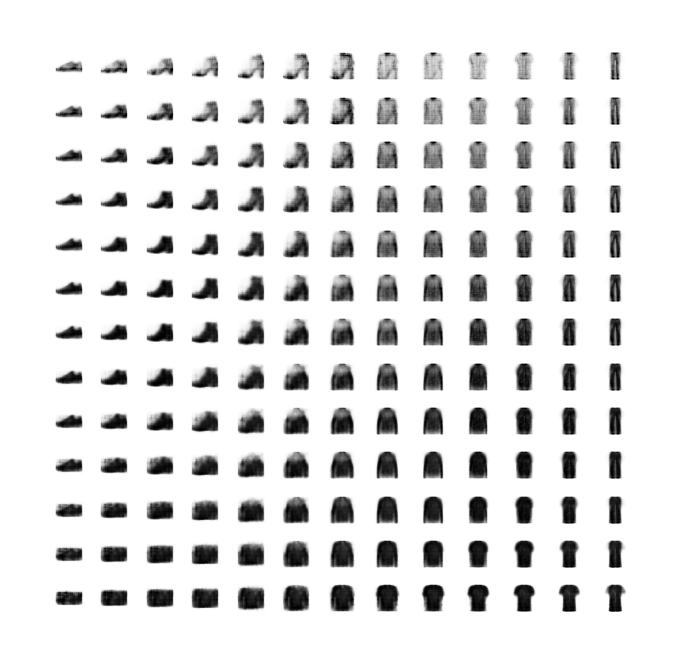

In [15]:
#explore latent space
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3)
plt.show()

figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")